# Классификация займов

<i>Проект выполнен в рамках формирования портфолио. Данные были взяты из открытого датасета с сайта Kaggle.</i>

<b>Цель</b>: обучить модель для предсказания будет ли одобрен займ при соответствующих условиях.

<b>Задачи</b>: 
1. Ознакомиться с представленными данными
2. Выполнить предобрабоку данных
3. Изучить данные на наличие выбросов, общие тенденции и корреляции.
4. Подготовить признаки для модели
5. Обучить модель
6. Проверить качество модели метриками.

## Импорт библиотек

In [4]:
#библиотека для работы с данными
import pandas as pd

#библиотека для математических операций
import numpy as np

# оценка выбросов
from scipy.stats import zscore

#библиотеки для построения графиков
import seaborn as sns
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix

# подготовка признаков для модели и разделение на выборки
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# библиотека для решения проблемы дисбаланса классов
from imblearn.combine import SMOTETomek

# модуль для создания пацплайна
from sklearn.pipeline import Pipeline

# модели классификации
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# метрики для оценки качества модели
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

## Загрузка данных

In [6]:
df = pd.read_csv('Desktop/csv файлики/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [7]:
df.shape

(45000, 14)

В даатсете 45 000 строк и 14 столбцов:

<b>person_age </b> - возраст человека;

<b>person_gender </b> - пол человека;

<b>person_education	 </b> - высший уровень образования;

<b>person_income </b> - годовой доход;

<b>person_emp_exp </b> - опыт работы в годах;

<b>person_home_ownership </b> - статус права собственности на жилье;

<b>loan_amnt </b> - запрашиваемая сумма кредита;

<b>loan_intent </b> - цель кредита;

<b>loan_int_rate </b> - процентная ставка по кредиту;

<b>loan_percent_income </b> - сумма кредита в процентах от годового дохода;

<b>cb_person_cred_hist_length </b> - длина кредитной истории в годах;

<b>credit_score </b> - кредитный рейтинг человека;

<b>previous_loan_defaults_on_file </b> - индикатор предыдущих невыплат кредита;

<b>loan_status </b> - статус одобрения кредита.


<b>Таргет </b> - loan_status.


## Предобработка данных

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

<i>Несоответствий в типах данных не обнаружено.</i>

In [12]:
df.duplicated().sum()

0

In [13]:
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

<b>Вывод:</b>

- дубликатов не обнаружено

- пропусков нет

- типы данных соответствуют

## Исследовательский анализ

In [16]:
# выделим названия столбцов с категориальными переменными и числовывыми
cat_col_names = df.select_dtypes(exclude = 'number').columns.to_list()
num_col_names = df.select_dtypes(include = 'number').columns.to_list()

### Работа с числовыми признаками

In [18]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


Отмечаем наличие аномалий и выбросов в данных:

- Максимальный возраст человека 144 года

- Опыт работы 125 лет

- Необходима дополнительная работа с данными

Построим гистограммы и ящики с усами для каждого количественного признака

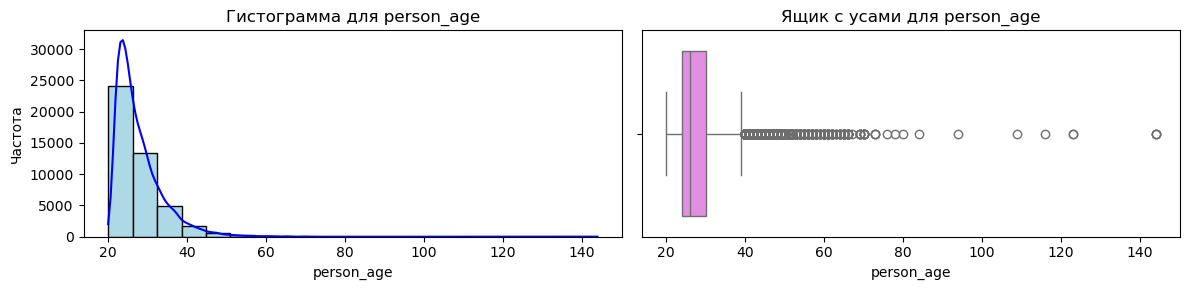

,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.0,24.0,26.0,30.0,144.0


Верхняя граница: 39.0, доля значений выше этой границы = 0.049 
Нижняя граница: 15.0, доля значений ниже этой границы = 0.0


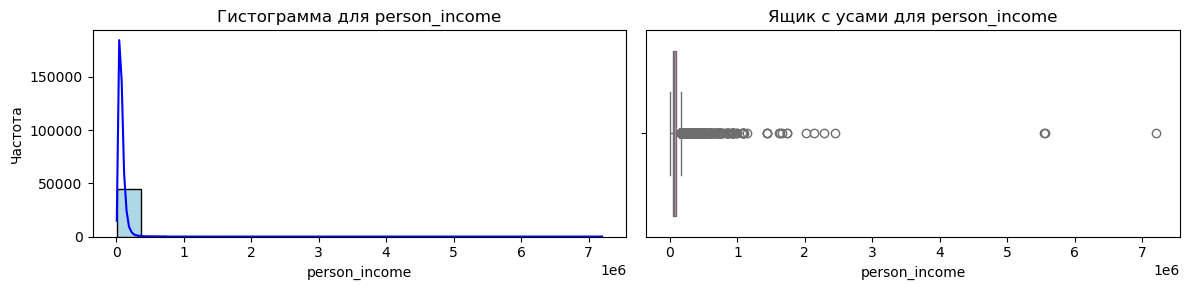

,count,mean,std,min,25%,50%,75%,max
person_income,45000.0,80319.053222,80422.498632,8000.0,47204.0,67048.0,95789.25,7200766.0


Верхняя граница: 168667.125, доля значений выше этой границы = 0.049 
Нижняя граница: -25673.875, доля значений ниже этой границы = 0.0


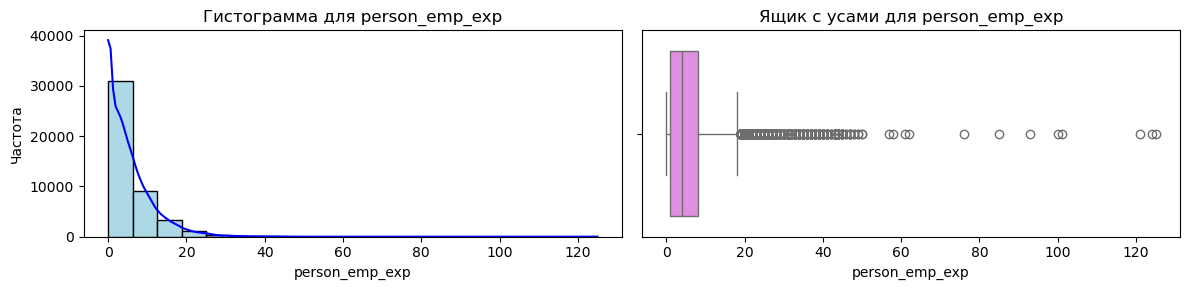

,count,mean,std,min,25%,50%,75%,max
person_emp_exp,45000.0,5.410333,6.063532,0.0,1.0,4.0,8.0,125.0


Верхняя граница: 18.5, доля значений выше этой границы = 0.038 
Нижняя граница: -9.5, доля значений ниже этой границы = 0.0


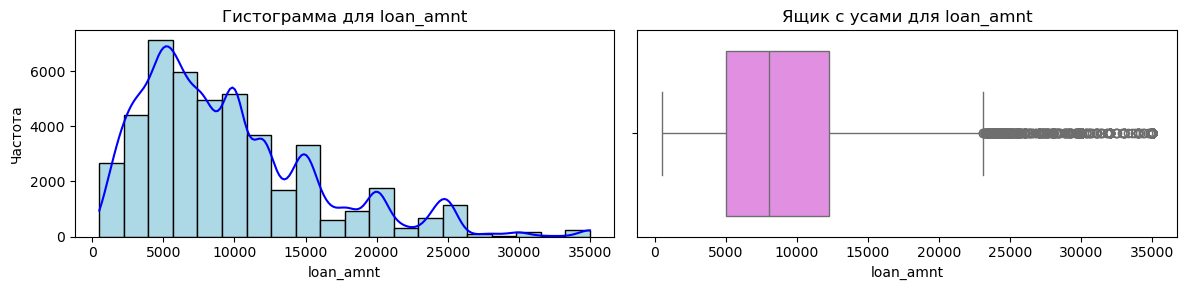

,count,mean,std,min,25%,50%,75%,max
loan_amnt,45000.0,9583.157556,6314.886691,500.0,5000.0,8000.0,12237.25,35000.0


Верхняя граница: 23093.125, доля значений выше этой границы = 0.052 
Нижняя граница: -5855.875, доля значений ниже этой границы = 0.0


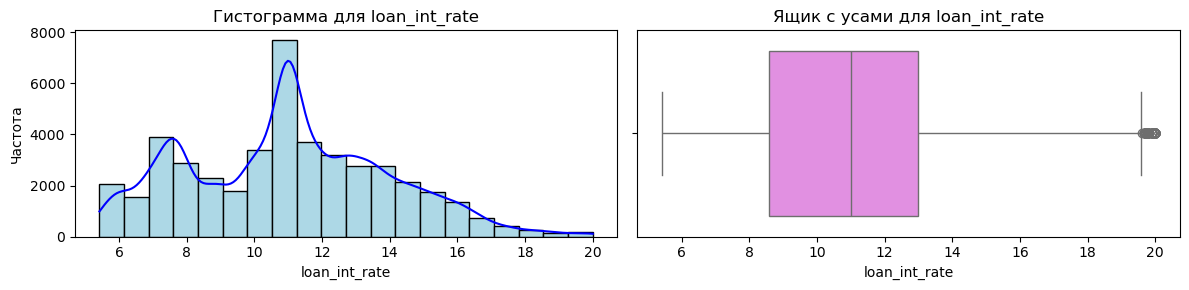

,count,mean,std,min,25%,50%,75%,max
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.0


Верхняя граница: 19.59, доля значений выше этой границы = 0.003 
Нижняя граница: 1.9899999999999993, доля значений ниже этой границы = 0.0


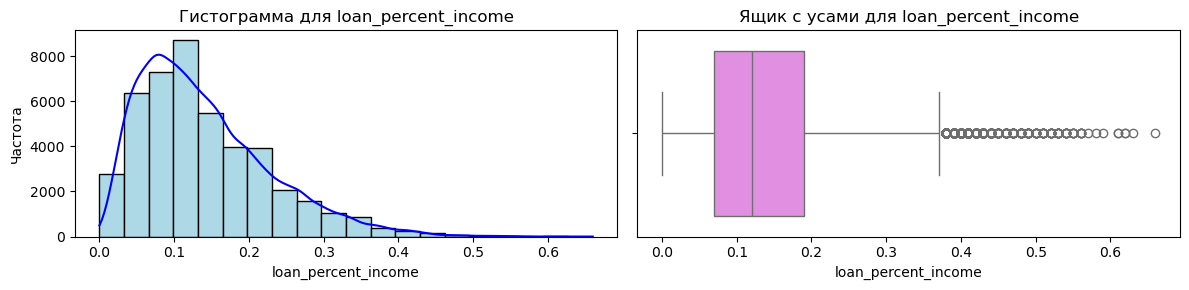

,count,mean,std,min,25%,50%,75%,max
loan_percent_income,45000.0,0.139725,0.087212,0.0,0.07,0.12,0.19,0.66


Верхняя граница: 0.37, доля значений выше этой границы = 0.017 
Нижняя граница: -0.10999999999999999, доля значений ниже этой границы = 0.0


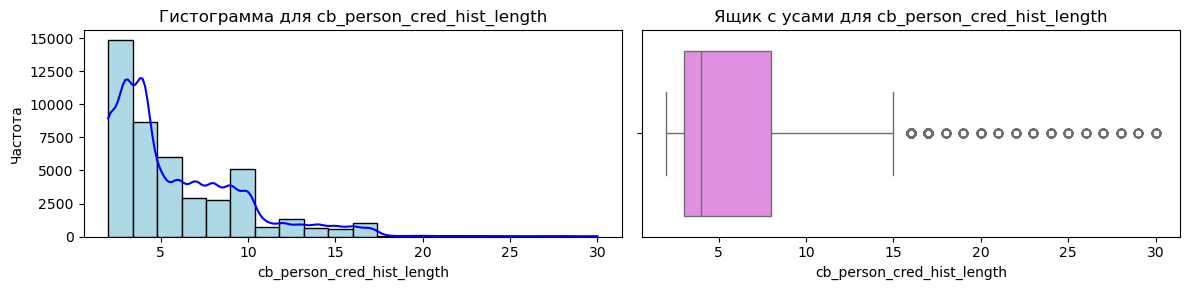

,count,mean,std,min,25%,50%,75%,max
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.0,3.0,4.0,8.0,30.0


Верхняя граница: 15.5, доля значений выше этой границы = 0.03 
Нижняя граница: -4.5, доля значений ниже этой границы = 0.0


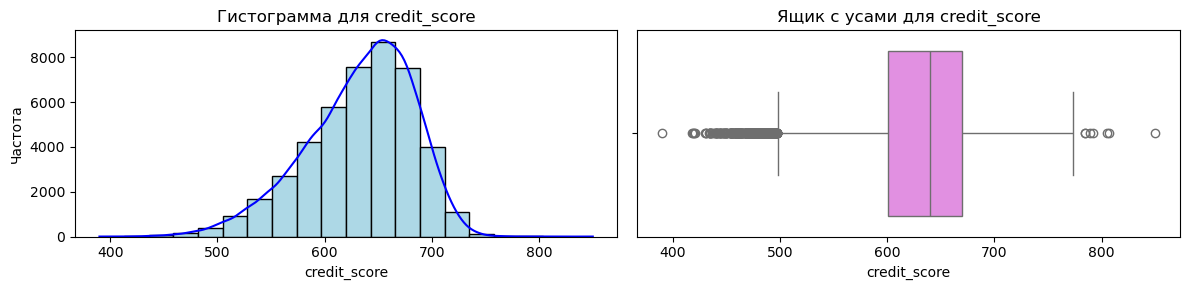

,count,mean,std,min,25%,50%,75%,max
credit_score,45000.0,632.608756,50.435865,390.0,601.0,640.0,670.0,850.0


Верхняя граница: 773.5, доля значений выше этой границы = 0.0 
Нижняя граница: 497.5, доля значений ниже этой границы = 0.01


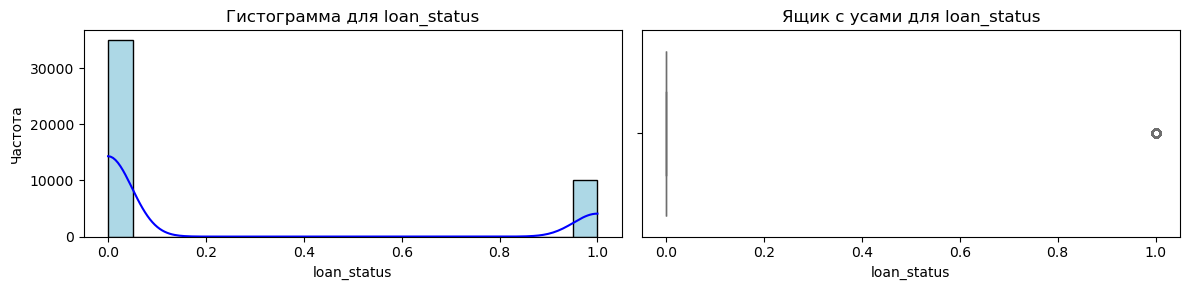

,count,mean,std,min,25%,50%,75%,max
loan_status,45000.0,0.222222,0.415744,0.0,0.0,0.0,0.0,1.0


Верхняя граница: 0.0, доля значений выше этой границы = 0.222 
Нижняя граница: 0.0, доля значений ниже этой границы = 0.0


In [21]:
for num_col in num_col_names:
    # Создаем фигуру с двумя столбцами
    fig, ax = plt.subplots(1, 2, figsize=(12, 3)) 

    # Гистограмма 
    sns.histplot(df[num_col], kde=True, bins=20, color='blue',facecolor='lightblue', ax=ax[0])
    ax[0].set_title(f'Гистограмма для {num_col}')
    ax[0].set_xlabel(num_col)
    ax[0].set_ylabel('Частота')

    # Ящик с усами 
    sns.boxplot(x=df[num_col], color='violet', ax=ax[1])
    ax[1].set_title(f'Ящик с усами для {num_col}')
    ax[1].set_xlabel(num_col)

    # Настраиваем макет и отображаем графики
    plt.tight_layout()
    plt.show()

    # Вывод описательной статистики
    display(df[num_col].describe().to_frame().T)

    # Нахождение выбросов
    Q1 = df[num_col].quantile(0.25)
    Q3 = df[num_col].quantile(0.75)
    IQR = Q3 - Q1
    print(f'Верхняя граница: {Q3 + (1.5 * IQR)}, доля значений выше этой границы = {round(df[df[num_col]>(Q3 + (1.5 * IQR))][num_col].count()/df[num_col].count(),3)} \nНижняя граница: {Q1 - (1.5 * IQR)}, доля значений ниже этой границы = {round(df[df[num_col]<(Q1 - (1.5 * IQR))][num_col].count()/df[num_col].count(),3)}')

Рассмотрим каждый признак отдельно:

<b>person_age:</b> 

- необходимо удалить аномалии: возраст > 100 лет;
  
- согласно методу с использованием межквартильного размахав выбросами считаются значения выше 39, они составляют 4,9% от общего объема данных;

- необходима дополнительная проверка перед определением порога выбросов, так как возраст заемщика может быть важным признаком.

<b>person_income:</b>

- в данных присутствуют выбросы;

- значения выбрососв составляют 4,9% от всех данных;

<b>person_emp_exp:</b>

- необходимо удалить аномалии: опыт работы >= 60 лет;

- присутствиют выбросы, значения  выше 18,5 (3,8%)

<b>loan_amnt:</b>

- присутствиют выбросы, значения  выше 23093,125 (5,2%);

-  самая частая сумма займа около 5 000

<b>loan_int_rate:</b>

- выявлено незначительное количество выбросов (0,3%);

- наиболее распространенная процентная ставка составляет 11 %;

- встречаются необычные наблюдения(5,42%), что может быть связано со льготами или акционными программами

<b>loan_percent_income:</b>

- немного значений было определено как выбросы (1,7%);

- не стоит избавляться от этих значений, так как они связаны с другими признаками(person_income);

- небольшие займы пользуются большей популярностью (10-20% от дохода заемщика)

<b>cb_person_cred_hist_length:</b>

- 3% от данных - выбросы
  
<b>credit_score:</b>

- имеются наблюдения с особо низким кредитным рейтингом;

- средний кредитный рейтинг в выборке 640

<b>loan_status:</b>

- наблюдается дисбаланс классов;

- наблюдений класса 0 примерно в три раза больше, чем 1

  <b>                                       Общие выводы:</b>
  - необходимо избавиться от аномалий в столбцах <i>person_age</i> и <i>person_emp_exp</i>
 
  - отдельно рассмотреть выбросы в столбце <i>person_age</i>
 
  - удалить выбросы в столбцах <i>person_income, person_emp_exp, loan_amnt, cb_person_cred_hist_length, credit_score </i>

  - учесть дисбаланс классов при обучении модели

#### Работа с признаком person_age

In [24]:
# создаем копию
df_age = df[['person_age','person_emp_exp']].copy()

In [25]:
#применяем z-оценку для выявления выбросов
df_age['z_score'] = zscore(df_age['person_age'])
df_age[df_age['z_score']>3]['person_age'].value_counts()

person_age
46.0     114
47.0     112
48.0      93
49.0      59
50.0      56
51.0      46
52.0      42
53.0      35
55.0      24
54.0      24
58.0      20
56.0      20
57.0      17
60.0      16
61.0      12
66.0      11
65.0      10
62.0       7
64.0       7
70.0       7
59.0       6
69.0       5
63.0       3
73.0       3
144.0      3
123.0      2
78.0       1
94.0       1
80.0       1
84.0       1
76.0       1
67.0       1
116.0      1
109.0      1
Name: count, dtype: int64

In [26]:
762/45000

0.016933333333333335

Видим, что при оценке выбрососв через Z-оценку процент наблюдений классифицированных как выбросы снизился. 

В силу специфики показателя возраста примем в дальнейшую работу только наблюдения людей младше 65 лет.

#### Удаление выбросов и аномалий

In [29]:
# удаляем значения с выбросами, согласно полученным границам
df = df[(df['person_age'] <= 65) & (df['person_income']<=168667.125) & (df['person_emp_exp']<=18.5) & (df['loan_amnt']<=23093.125)& (df['cb_person_cred_hist_length']<= 15.5) & (df['credit_score']>=497.5)]

In [30]:
df.shape

(38502, 14)

После удаления выбросов осталось около 85% исходных данных.

### Работа с категориальными переменными

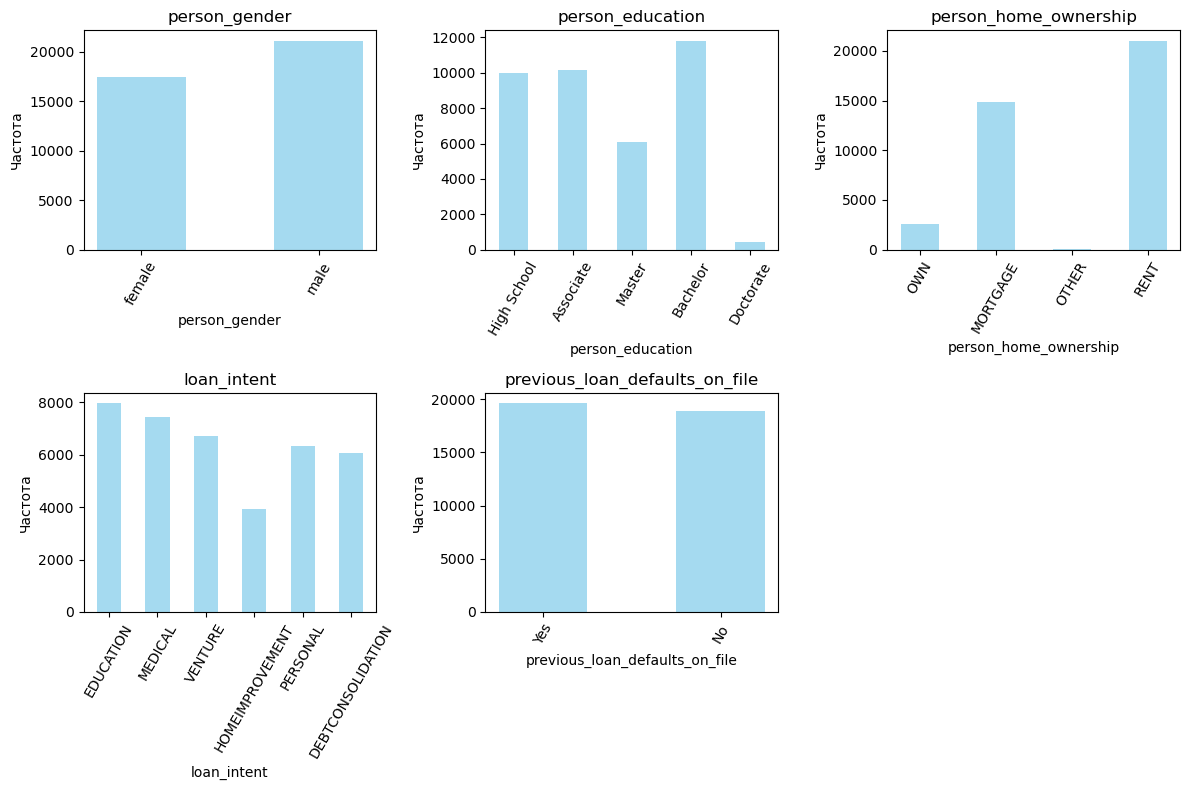

In [33]:
# Количество столбцов и строк
n_cols = 3
n_rows = (len(cat_col_names) + n_cols - 1) // n_cols  # Расчёт количества строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))  
axes = axes.flatten()  

# Построение графиков
for idx, cat_col in enumerate(cat_col_names):
    sns.histplot(df[cat_col], bins=50, ax=axes[idx], shrink = 0.5, color = 'skyblue', edgecolor = 'none')  # Построение гистограммы на текущей оси
    axes[idx].set_title(f'{cat_col}')
    axes[idx].set_xlabel(f'{cat_col}')
    axes[idx].set_ylabel('Частота')
    axes[idx].tick_params(axis='x', rotation=60)  # Поворот подписей оси X

# Удаление лишних осей
for idx in range(len(cat_col_names), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [34]:
df[cat_col_names].describe().T

,count,unique,top,freq
person_gender,38502,2,male,21095
person_education,38502,5,Bachelor,11813
person_home_ownership,38502,4,RENT,21007
loan_intent,38502,6,EDUCATION,7968
previous_loan_defaults_on_file,38502,2,Yes,19628


<b>Выводы:</b>

1. Большинство наблюдений составляют мужчины;

2. Чаще ввсего займ берут на образование, также большую часть заемщиков составляют бакалавры

3. Преимущественно заемщики снимают недвижимость в аренду, и имеют опыт просрочек платежа по предыдущим займам

### Корреляционная матрица

<Figure size 800x800 with 0 Axes>

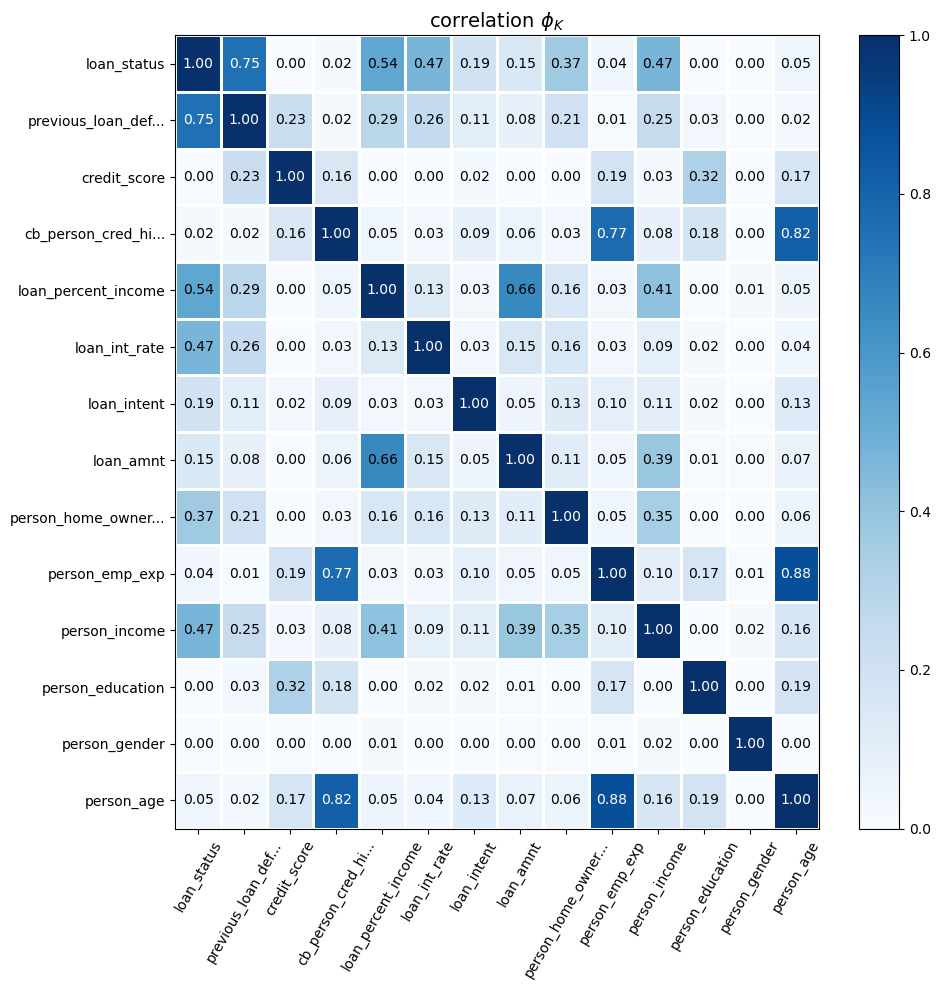

In [37]:
# используем phik для работы с категориальными и количественными признаками одновременно
phik_overview = df.phik_matrix(interval_cols=num_col_names)
plt.figure(figsize = (8,8))
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.xticks(rotation = 60) 
plt.tight_layout()
plt.show()

- Наблюдается сильная корреляция между тремя признаками <i> person_age, cb_person_credit_hist_length, person_emp_exp</i>, стоит удалить один из этих признаков. Среди этих признаков самая низкая корреляйия с таргетом у cb_person_credit_hist_length.

- Высокая корреляция таргета и <i>previous_loan_defaults_on_file</i>

In [39]:
df = df.drop('cb_person_cred_hist_length', axis = 1)

## Подготовка данных к обучению модели

### Разделение на тестовую и тренировочную выборки

In [42]:
# разделяем датасет на features & target
X = df.drop('loan_status', axis =1)
y= df['loan_status']
# делим на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
X_train.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,credit_score,previous_loan_defaults_on_file
18816,33.0,male,Associate,64846.0,9,RENT,1200.0,MEDICAL,16.29,0.02,545,No
536,25.0,male,Associate,57546.0,3,RENT,21250.0,VENTURE,10.99,0.37,610,No
37841,28.0,male,High School,30764.0,6,RENT,5000.0,EDUCATION,10.97,0.16,682,Yes
37764,24.0,female,High School,144954.0,5,MORTGAGE,2464.0,EDUCATION,11.53,0.02,552,Yes
4743,25.0,male,Associate,36788.0,7,RENT,5000.0,EDUCATION,11.86,0.14,655,Yes


### Масштабирование количественных признаков

In [44]:
num_col_names = X_train.select_dtypes(include = 'number').columns.to_list()
# инициируем модель для масштабирования
scaler = StandardScaler()
#обучаем и применяем к данным
X_train_scalled = scaler.fit_transform(X_train[num_col_names])
X_test_scalled = scaler.transform(X_test[num_col_names])

In [45]:
# преобразуем масштабированные данные в дф
X_train_scalled = pd.DataFrame(X_train_scalled, columns=num_col_names)
X_test_scalled = pd.DataFrame(X_test_scalled, columns=num_col_names)

### Кодирование категориальных переменных

In [47]:
cat_col_names = X_train.select_dtypes(exclude = 'number').columns.to_list()
# иниуциализируем модель
encoder = OneHotEncoder(drop = 'first', sparse_output = False)
# кодируем категориальные переменные
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

In [48]:
# получаем новые названия столбов
encoder_col_names = encoder.get_feature_names_out()

In [49]:
# преобразуем закодированные данные в дф
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [50]:
# перед объединением данных после преобразований сбрасываем индексы
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [51]:
# объединяем данные
X_train = pd.concat((X_train_scalled, X_train_ohe), axis=1)
X_test = pd.concat((X_test_scalled, X_test_ohe), axis=1)

In [52]:
X_train.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,credit_score,person_gender_male,person_education_Bachelor,person_education_Doctorate,...,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,1.451788,-0.138047,1.079289,-1.487418,1.811129,-1.414968,-1.840553,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.401121,-0.368999,-0.321053,2.578539,0.024996,2.774052,-0.477861,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.293720,-1.216308,0.379118,-0.716812,0.018255,0.260640,1.031583,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.632734,2.396350,0.145728,-1.231090,0.206979,-1.414968,-1.693802,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.401121,-1.025725,0.612508,-0.716812,0.318191,0.021267,0.465542,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


### Дисбаланс классов

<Axes: xlabel='loan_status'>

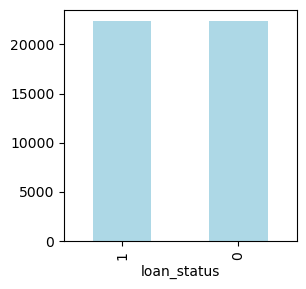

In [54]:
# сэмплируем данные
sampler = SMOTETomek(random_state = 42)
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
y_train_sampled.value_counts().plot(kind = 'bar', color = 'lightblue', figsize = (3,3))

<b>Вывод:</b> после применения SMOTETomek количество наблюдений разных классов стало <i>одинаковым</i>

## Обучение модели

In [57]:
# инициализируем пайплайн
pipeline = Pipeline([('model', LogisticRegression())]) # модель-заглушка

In [58]:
# создаем список словарей с параметрами
parameters = [{'model':[LogisticRegression(random_state = 42, class_weight='balanced')],
               'model__penalty': ['l1','l2']},
              {'model':[SVC(random_state = 42, class_weight='balanced')],
               'model__kernel':['linear', 'rbf', 'sigmoid']},
              {'model':[KNeighborsClassifier()], 
               'model__n_neighbors': range(1,31),
               'model__metric': ['euclidean', 'manhattan']},
              {'model': [DecisionTreeClassifier(random_state = 42, class_weight='balanced')],
               'model__max_depth': range(1,21),
               'model__criterion': ['gini', 'entropy'],
               'model__min_samples_split': range(2,21),
               'model__min_samples_leaf': range(1,11)}]


In [59]:
# используем RandomizedSearchCV для подбоа лучшей модели
rscv = RandomizedSearchCV(pipeline,parameters,random_state = 42, n_iter = 100, n_jobs=-1, cv = 5, scoring = 'roc_auc')

In [60]:
# запускаем поиск
rscv.fit(X_train_sampled, y_train_sampled)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('model', LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'model': [LogisticRegression(class_weight='balanced',
                                                                      random_state=42)],
                                         'model__penalty': ['l1', 'l2']},
                                        {'model': [SVC(class_weight='balanced',
                                                       random_state=42)],
                                         'model__kernel': ['linear', 'rbf',
                                                           'sigmoid']},
                                        {'model': [KNeighborsClassifier()],
                                         'model__metric': ['euclidean',
                                                           'manhattan'],
                                         'model__n_neighbors': range(1, 31)},
                                        {'model': [DecisionTreeClassifier(class_weight='balanced',
                                                                          random_state=42)],
                                         'model__criterion': ['gini',
                                                              'entropy'],
                                         'model__max_depth': range(1, 21),
                                         'model__min_samples_leaf': range(1, 11),
                                         'model__min_samples_split': range(2, 21)}],
                   random_state=42, scoring='roc_auc')

In [61]:
# Лучшие параметры и оценка
print("Лучшие параметры:", rscv.best_params_)
print("Лучшая оценка на кросс-валидации:", rscv.best_score_)

Лучшие параметры: {'model__min_samples_split': 3, 'model__min_samples_leaf': 9, 'model__max_depth': 11, 'model__criterion': 'gini', 'model': DecisionTreeClassifier(class_weight='balanced', random_state=42)}
Лучшая оценка на кросс-валидации: 0.9735814495428731


In [62]:
# Оценка на тестовой выборке (обучение на сэмплированных данных)
y_pred = rscv.predict(X_test)
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))


Отчет по классификации:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      7496
           1       0.72      0.85      0.78      2130

    accuracy                           0.89      9626
   macro avg       0.84      0.88      0.85      9626
weighted avg       0.90      0.89      0.90      9626



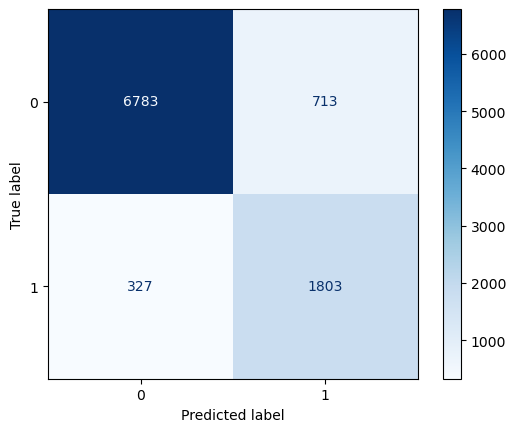

In [63]:
# Матрица ошибок модели, обученной на сэмплированных данных
ConfusionMatrixDisplay.from_estimator(rscv, X_test, y_test, cmap = 'Blues')

In [64]:
# обучение на несэмплированных данных
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('model', LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'model': [LogisticRegression(class_weight='balanced',
                                                                      random_state=42)],
                                         'model__penalty': ['l1', 'l2']},
                                        {'model': [SVC(class_weight='balanced',
                                                       random_state=42)],
                                         'model__kernel': ['linear', 'rbf',
                                                           'sigmoid']},
                                        {'model': [KNeighborsClassifier()],
                                         'model__metric': ['euclidean',
                                                           'manhattan'],
                                         'model__n_neighbors': range(1, 31)},
                                        {'model': [DecisionTreeClassifier(class_weight='balanced',
                                                                          random_state=42)],
                                         'model__criterion': ['gini',
                                                              'entropy'],
                                         'model__max_depth': range(1, 21),
                                         'model__min_samples_leaf': range(1, 11),
                                         'model__min_samples_split': range(2, 21)}],
                   random_state=42, scoring='roc_auc')

In [65]:
# лучшие параметры и оценка(несэмплированные данные)
print("Лучшие параметры:", rscv.best_params_)
print("Лучшая оценка на кросс-валидации:", rscv.best_score_)

Лучшие параметры: {'model__min_samples_split': 15, 'model__min_samples_leaf': 8, 'model__max_depth': 9, 'model__criterion': 'gini', 'model': DecisionTreeClassifier(class_weight='balanced', random_state=42)}
Лучшая оценка на кросс-валидации: 0.9635423707492073


In [66]:
# Оценка на тестовой выборке (обучение на несэмплированных данных)
y_pred = rscv.predict(X_test)
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))


Отчет по классификации:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      7496
           1       0.68      0.90      0.77      2130

    accuracy                           0.88      9626
   macro avg       0.82      0.89      0.85      9626
weighted avg       0.90      0.88      0.89      9626



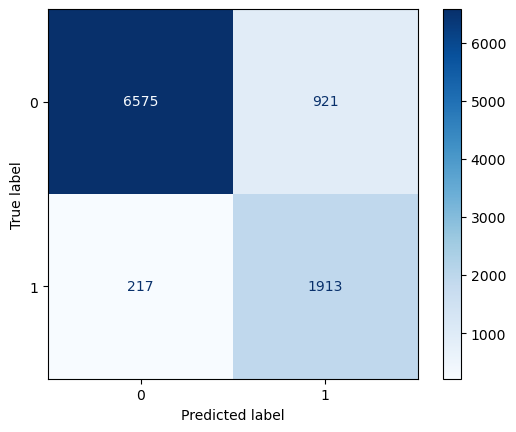

In [67]:
# матрица ошибок модели, обученной на несэмплированных данных
ConfusionMatrixDisplay.from_estimator(rscv, X_test, y_test, cmap = 'Blues')

<b>Вывод:</b> 

- В ходе подбора было выявлено, что модель DecisionTreeClassifier показывает лучший результат

        - на сэмплированных данных при гиперпараметрах: min_samples_split: 3, min_samples_leaf:9, max_depth: 11, criterion: gini

        - на несэмплированных данных при гиперпараметрах: min_samples_split: 15, min_samples_leaf: 8, max_depth: 9, criterion: gini


- Сэмплирование данных немного помогло решить проблему дисбаланса классов, так как метрики моделей близки;

- Можно отметить, что модель, обучавшаяся на сэмплированных данных нменого лучше предсказывает класс;

- Модель допускает ошибки первого рода в 10% случаев, второго рода в 2%;

- Процент верных предсказаний 88%.

## Интерпретация модели

In [121]:
# создадим таблицу с оценкой значимости признаков
feature_importance = pd.DataFrame({'Feature': X_train.columns,
        'Importance': rscv.best_estimator_.named_steps['model'].feature_importances_}).sort_values('Importance', ascending=False)

<Axes: xlabel='Importance', ylabel='Feature'>

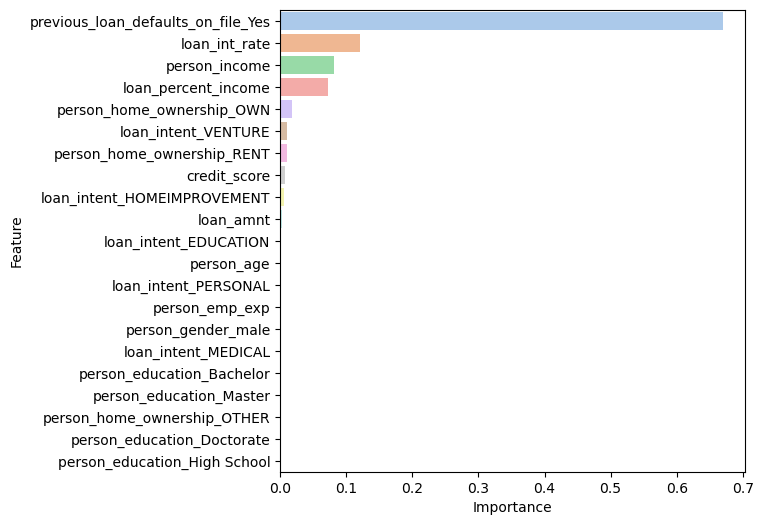

In [71]:
# визуализируем значимость признаков
plt.figure(figsize = (6,6))
sns.barplot(data = feature_importance, x = 'Importance', y= 'Feature', palette = 'pastel', hue=feature_importance['Feature'] )

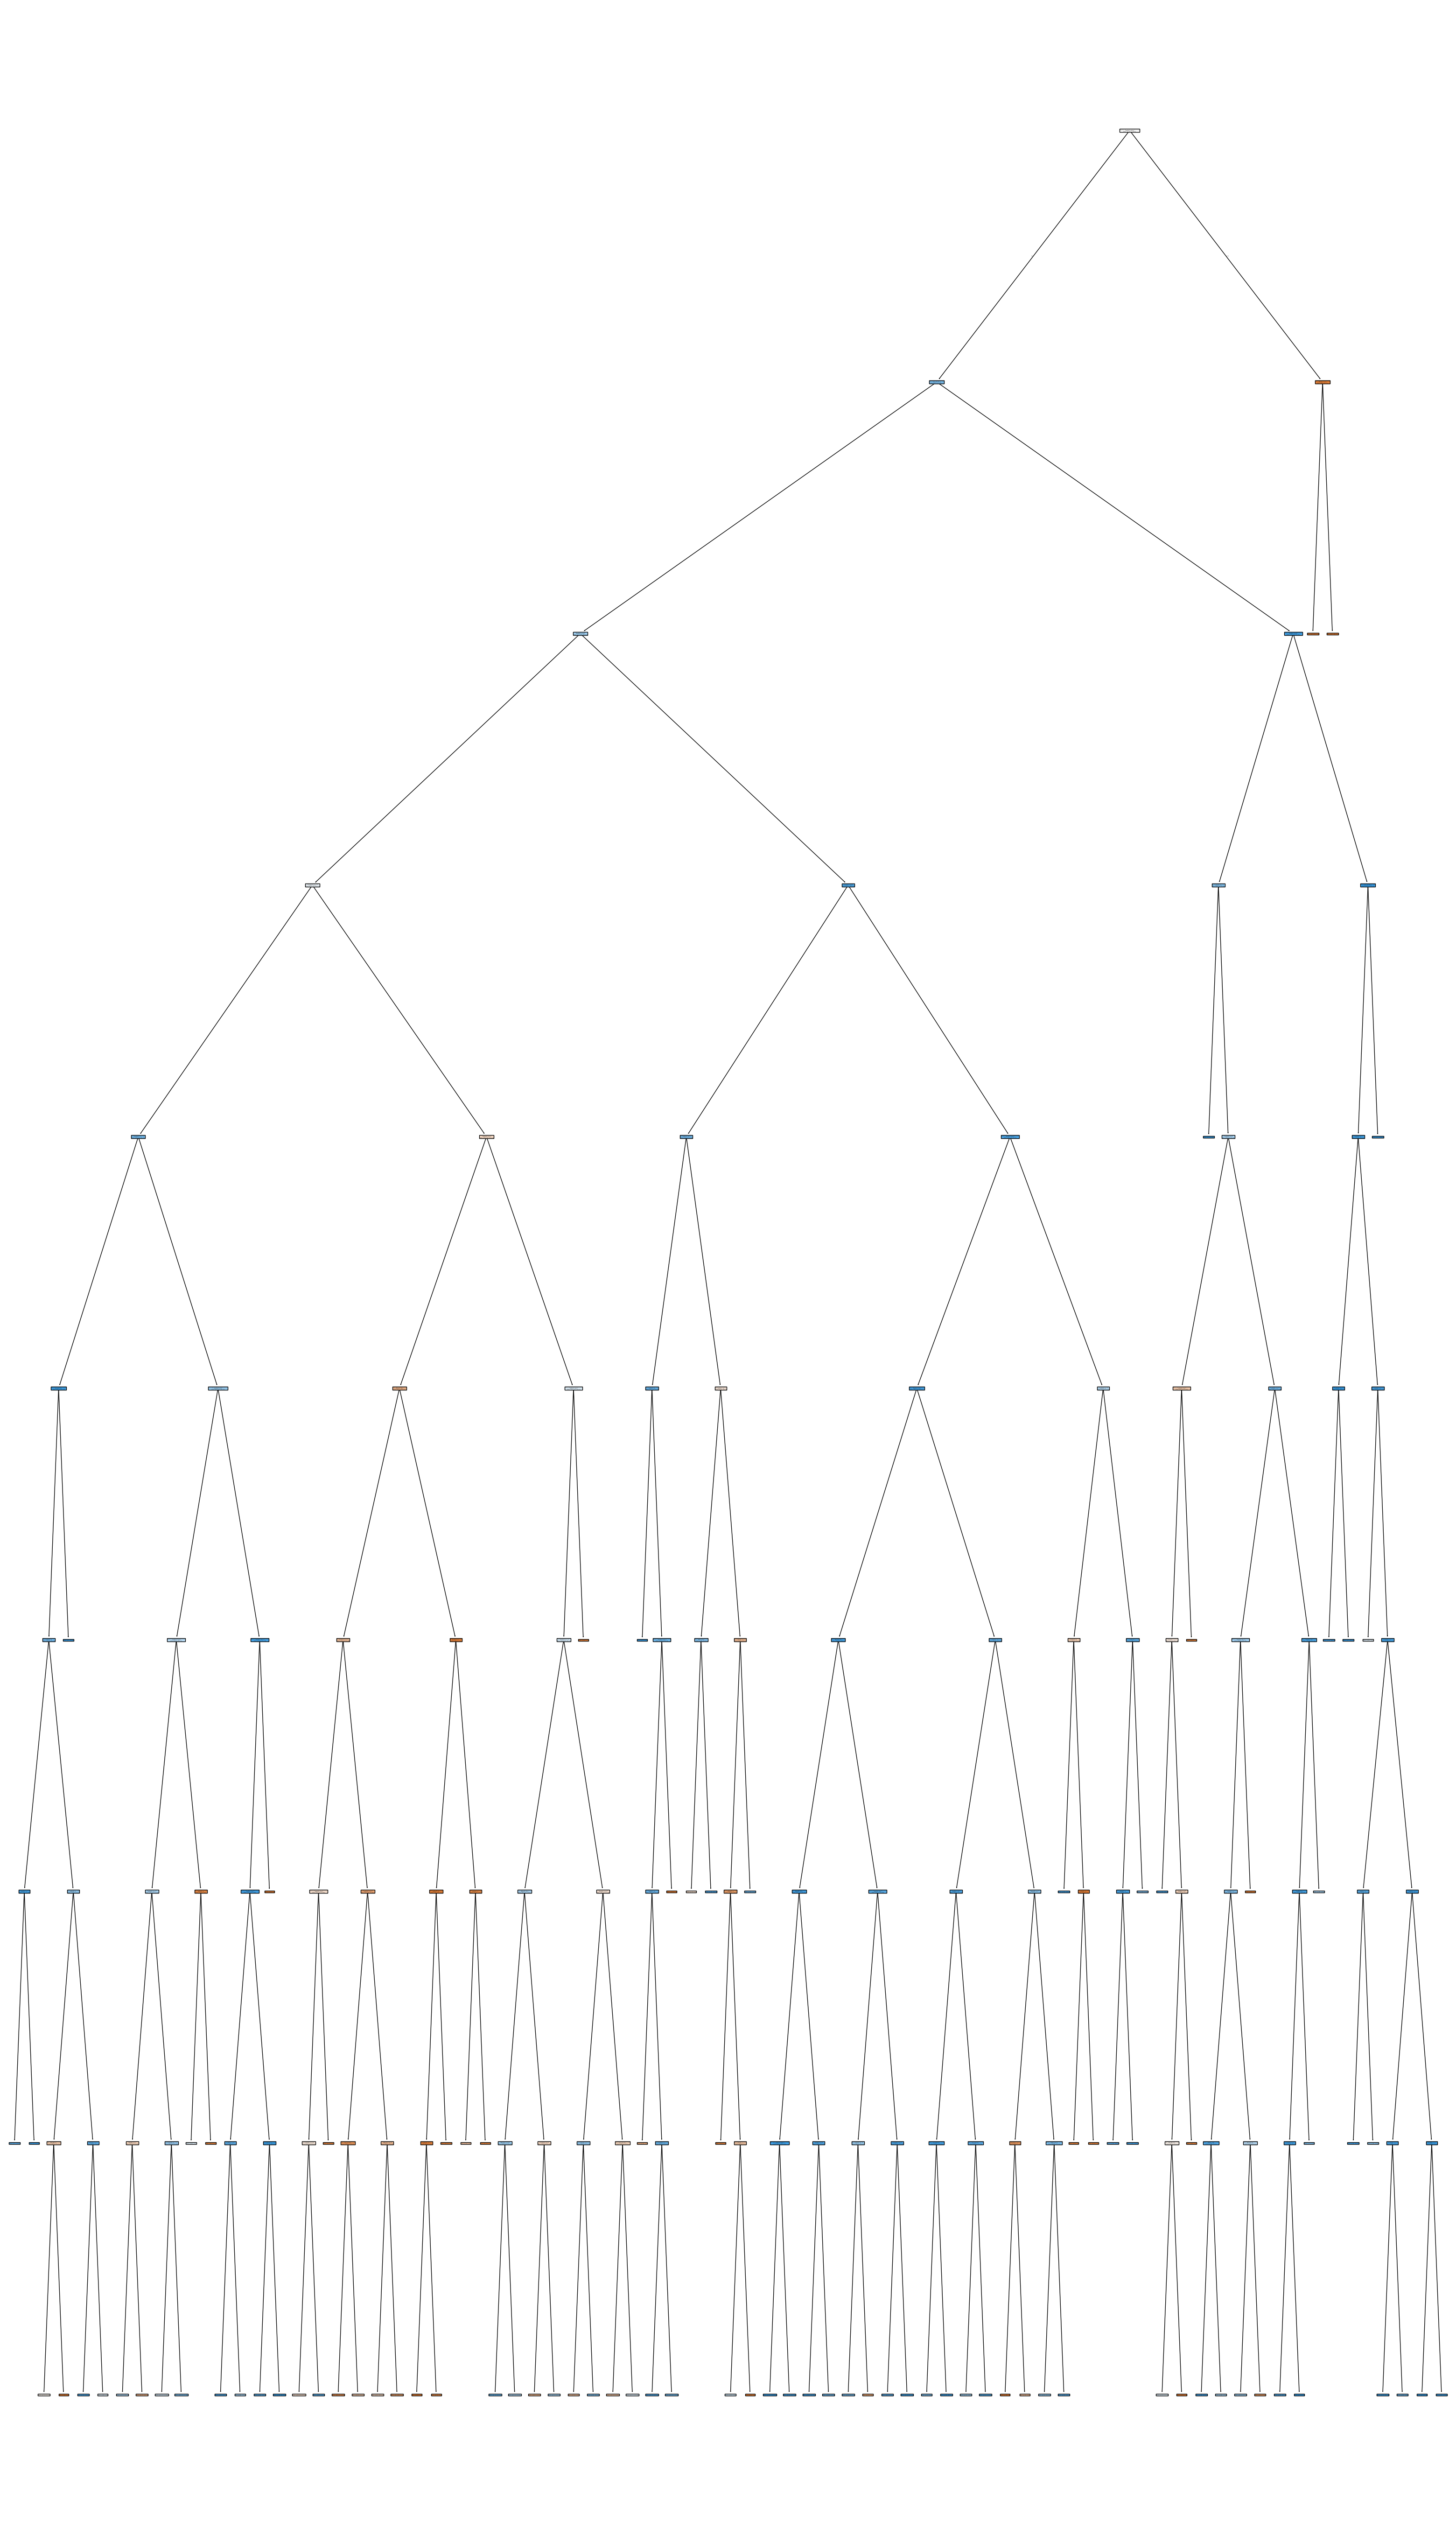

In [72]:
fig = plt.figure(figsize = (40,70))
_ = plot_tree(rscv.best_estimator_.named_steps['model'], filled=True, impurity=False, feature_names=X_train.columns);

In [73]:
fig.savefig("decision_tree clf.png")

In [74]:
print(export_text(rscv.best_estimator_.named_steps['model'],feature_names=list(X_train.columns)))

|--- previous_loan_defaults_on_file_Yes <= 0.50
|   |--- loan_percent_income <= 1.28
|   |   |--- loan_int_rate <= 0.91
|   |   |   |--- person_income <= -0.85
|   |   |   |   |--- person_income <= -1.42
|   |   |   |   |   |--- loan_percent_income <= -0.16
|   |   |   |   |   |   |--- person_income <= -1.70
|   |   |   |   |   |   |   |--- loan_int_rate <= -0.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- loan_int_rate >  -0.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- person_income >  -1.70
|   |   |   |   |   |   |   |--- person_income <= -1.48
|   |   |   |   |   |   |   |   |--- loan_intent_MEDICAL <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- loan_intent_MEDICAL >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- person_income >  -1.48
|   |   |   |   |   |   |   |   |--- credit_score <= 0.99
|   |   |   |   |   |   |   |   | 


1. Наиболее значимми признаками в определении получения займа стали:

            - previous_loan_defaults_on_file_Yes (наличие просроченных платежей по предыдущим займам)

            - loan_int_rate (процентная ставка)

            - person_income (доход заемщика)

            - loan_percent_income (процент, который составляет займ от общего дохода)

   

3. Дерево получилось большим, его трудно интерпретировать, однако можно вывести правила назначения класса в тексте.

4. Корневым узлом дерева является: previous_loan_defaults_on_file_Yes

## Выводы


1. В ходе работ был изучен датасет в данными о заемщиках, одобрении или отклонении заяки на кредит:

        - Были выявлены и обработаны выбросы и аномалии

        - Проанализированы корреляционные связи между призаками и таргетом;

        - Промасштабированы количественные и закодированы категориальные признаки;
   
        - Применен метод сэмплирования SMOTETomek для сглаживания дисбаланса классов;

        - Подобраны лучшие параметры и лучшая модель посредством использования пайплайна и RandomizedSearcgCV

        - Проанализирована интерпретация модели.
   
2.  Была обучена модель DecisionTreeClassifier, которая предсказывает одобрение/неодобрение кредита заемщику на основе исходных признаков, точность модели составляет 88%

3. Выявлено, что наибольшее влияние оказывает:

        - наличие просорченных платежей по прошлым займам;
   
        - процентная ставка;
   
        - доход заемщика;
   
       - процент займа от дохода;

4. Не оказывают влияния следующие признаки:

        - степень образования;
   
        - сумма займа;
   
        - возраст.
